In [1]:
# ===============================================================
# LexGLUE → CaseHOLD (Google Colab End-to-End) — Clean, Colab-safe
# ===============================================================


# ======================
# 0) Install & Imports
# ======================
!pip -q install -U "transformers==4.55.0" "datasets>=2.20.0" "accelerate>=0.33.0" "evaluate==0.4.2" "wordcloud>=1.9.3"

import os
import json
import random
from dataclasses import dataclass
from typing import Optional, Union, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForMultipleChoice,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_utils import IntervalStrategy

from wordcloud import WordCloud, STOPWORDS

# Ensure reproducibility
set_seed(42)

# ======================
# 1) Config (Colab-safe defaults)
# ======================
class CFG:
    dataset_name = "coastalcph/lex_glue"
    subset_name  = "case_hold"
    model_name   = "nlpaueb/legal-bert-base-uncased"  # swap to "bert-base-uncased" or "roberta-base" if needed

    # Colab-friendly settings
    max_length = 128
    per_device_train_batch_size = 2
    per_device_eval_batch_size  = 2
    gradient_accumulation_steps = 4
    num_train_epochs = 2
    learning_rate = 2e-5
    weight_decay = 0.01
    warmup_ratio = 0.06
    logging_steps = 50

    # Strategy args (note: eval_strategy is the correct kwarg in your version)
    eval_strategy = IntervalStrategy.EPOCH
    save_strategy = IntervalStrategy.EPOCH

    # Mixed precision if GPU
    fp16 = torch.cuda.is_available()

    # Optional: quick subset training for smoke tests
    SMALL_RUN = True           # set False to train on full data
    SMALL_TRAIN_N = 4000       # samples from train
    SMALL_VAL_N   = 800        # samples from validation

    # Explainability toggles (kept light)
    DO_ATTENTION_DEMO = True
    ATTENTION_SAMPLES = 1      # tiny demo since MC attentions are large


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
Device: cuda


In [2]:
# ======================
# 2) Load Dataset
# ======================
ds: DatasetDict = load_dataset(CFG.dataset_name, CFG.subset_name)
print(ds)

# Optional small-run subset (to make sure end-to-end works fast)
train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]

if CFG.SMALL_RUN:
    train_ds = train_ds.select(range(min(CFG.SMALL_TRAIN_N, len(train_ds))))
    val_ds   = val_ds.select(range(min(CFG.SMALL_VAL_N, len(val_ds))))

print(f"Train subset size: {len(train_ds)} / {len(ds['train'])}")
print(f"Val subset size  : {len(val_ds)} / {len(ds['validation'])}")
print(f"Test size        : {len(test_ds)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

case_hold/train-00000-of-00001.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

case_hold/test-00000-of-00001.parquet:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

case_hold/validation-00000-of-00001.parq(…):   0%|          | 0.00/3.51M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3900 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3600
    })
    validation: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3900
    })
})
Train subset size: 4000 / 45000
Val subset size  : 800 / 3900
Test size        : 3600


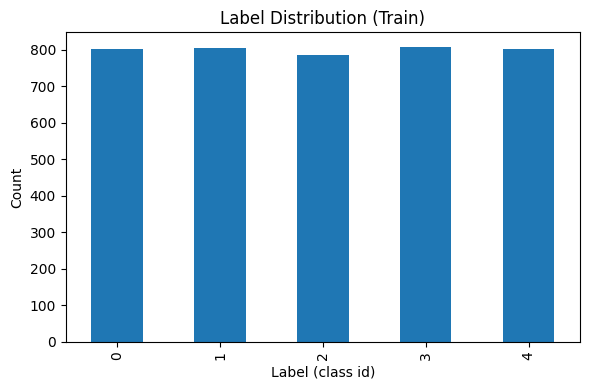

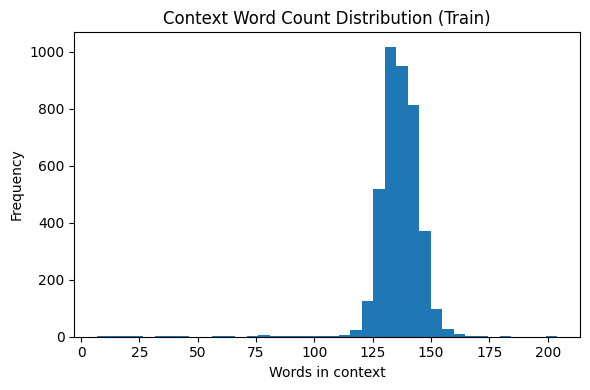

Context word count stats (Train):
count    4000.000000
mean      136.212750
std        10.339812
min         7.000000
25%       132.000000
50%       137.000000
75%       141.000000
max       204.000000
Name: context, dtype: float64


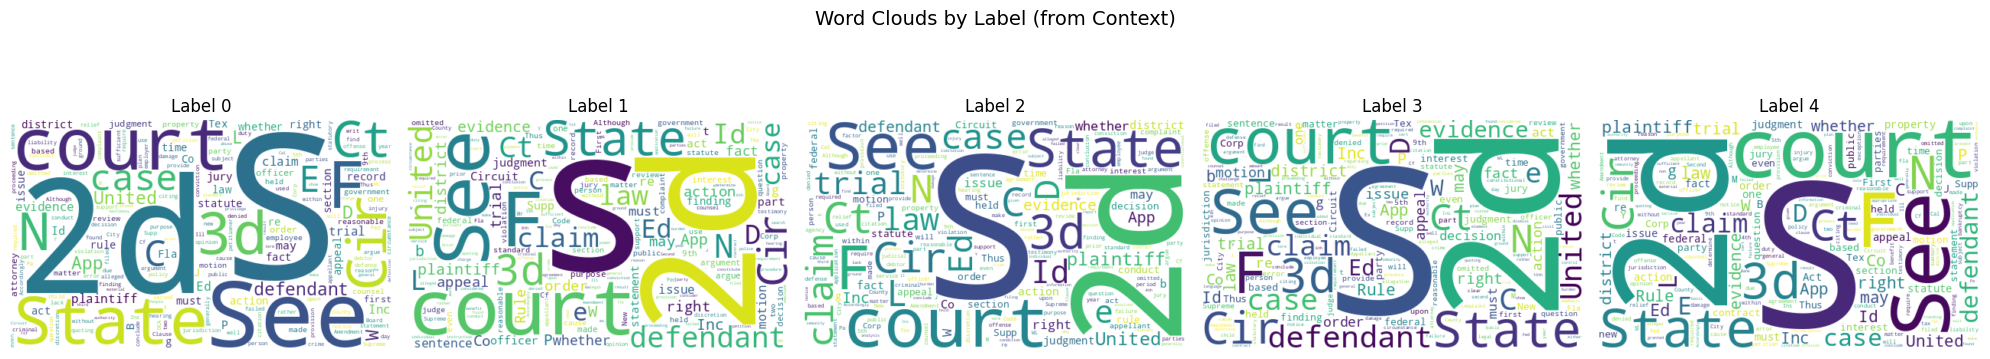


Sample example:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           context                                                                                                                                     

In [3]:
# ======================
# 3) EDA (treat label as categorical)
#   - Label distribution
#   - Context length distribution
#   - Word clouds per label (sampled, to keep it fast)
# ======================

# Convert a slice of data to DataFrame for EDA
def to_df(dataset, max_rows=10000):
    n = min(max_rows, len(dataset))
    return pd.DataFrame(dataset.select(range(n))[:])

eda_df_train = to_df(train_ds, max_rows=10000)
eda_df_val   = to_df(val_ds,   max_rows=5000)
eda_df_test  = to_df(test_ds,  max_rows=5000)

# 3.1 Label distribution (categorical)
plt.figure(figsize=(6,4))
eda_df_train['label'] = eda_df_train['label'].astype('category')
eda_df_train['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Label Distribution (Train)")
plt.xlabel("Label (class id)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3.2 Context length distribution
ctx_lens = eda_df_train['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
plt.hist(ctx_lens, bins=40)
plt.title("Context Word Count Distribution (Train)")
plt.xlabel("Words in context")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Context word count stats (Train):")
print(pd.Series(ctx_lens).describe())

# 3.3 Word Clouds per class label (sampled for speed)
stopwords = set(STOPWORDS) | {"<HOLDING>", "holding", "v", "u", "§", "§§"}  # add simple legal-ish stopwords
max_per_label_wc = 400  # keep small to avoid long processing

fig, axes = plt.subplots(1, 5, figsize=(20,4))
for lbl in range(5):
    subset = eda_df_train[eda_df_train['label'] == lbl]['context'].head(max_per_label_wc)
    text = " ".join(subset.astype(str).tolist())
    if len(text.strip()) == 0:
        text = "No text"
    wc = WordCloud(width=500, height=300, background_color="white", stopwords=stopwords, collocations=False).generate(text)
    axes[lbl].imshow(wc, interpolation="bilinear")
    axes[lbl].axis('off')
    axes[lbl].set_title(f"Label {lbl}")
plt.suptitle("Word Clouds by Label (from Context)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 3.4 Peek at one sample
print("\nSample example:")
print(eda_df_train[['context','endings','label']].head(1).to_string(index=False))


In [4]:
# ======================
# 4) Tokenizer & Preprocessing for Multiple-Choice
# ======================
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name, use_fast=True)

def preprocess_function(examples):
    # For multiple-choice: we create 5 pairs (context, ending_i)
    first_sentences = [[ctx] * 5 for ctx in examples["context"]]
    choice_texts    = examples["endings"]
    flat_ctx    = sum(first_sentences, [])
    flat_choice = sum(choice_texts, [])
    tokenized = tokenizer(
        flat_ctx,
        flat_choice,
        truncation=True,
        max_length=CFG.max_length,
        padding=False,  # let collator handle padding
    )
    # Un-flatten (group back by 5 choices)
    result = {k: [v[i:i+5] for i in range(0, len(v), 5)] for k, v in tokenized.items()}
    result["labels"] = examples["label"]
    return result

encoded_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
encoded_val   = val_ds.map(preprocess_function,   batched=True, remove_columns=val_ds.column_names)
encoded_test  = test_ds.map(preprocess_function,  batched=True, remove_columns=test_ds.column_names)

print(encoded_train)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 4000
})


In [5]:
# ======================
# 5) Data Collator (Multiple-Choice, pad at batch-time)
# ======================
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: AutoTokenizer
    padding: Union[bool, str] = True
    max_length: Optional[int] = None

    def __call__(self, features):
        labels = [f["labels"] for f in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        # flatten choices
        flattened = []
        for f in features:
            for i in range(num_choices):
                item = {
                    "input_ids": f["input_ids"][i],
                    "attention_mask": f["attention_mask"][i],
                }
                if "token_type_ids" in f:
                    item["token_type_ids"] = f["token_type_ids"][i]
                flattened.append(item)
        # pad
        batch = self.tokenizer.pad(
            flattened,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors="pt",
        )
        # unflatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.long)
        return batch

data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding=True)


In [6]:
# ======================
# 6) Metrics
# ======================
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}


In [7]:
# ======================
# 7) Model  (patched: force eager attention impl)
# ======================
def create_model():
    model = AutoModelForMultipleChoice.from_pretrained(
        CFG.model_name,
        attn_implementation="eager",   # <-- avoid SDPA fallback warning
    )
    return model.to(device)

In [8]:
# ======================
# 8) Train / Eval (Single Run) — FIXED
# ======================
def single_run_train_eval():
    model = create_model()

    args = TrainingArguments(
        output_dir="/content/tmp_casehold",
        num_train_epochs=CFG.num_train_epochs,
        per_device_train_batch_size=CFG.per_device_train_batch_size,
        per_device_eval_batch_size=CFG.per_device_eval_batch_size,
        gradient_accumulation_steps=CFG.gradient_accumulation_steps,
        eval_strategy=CFG.eval_strategy,       # correct kwarg for your version
        save_strategy=CFG.save_strategy,
        learning_rate=CFG.learning_rate,
        weight_decay=CFG.weight_decay,
        warmup_ratio=CFG.warmup_ratio,
        logging_steps=CFG.logging_steps,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        fp16=CFG.fp16,
        report_to="none",
        save_total_limit=1,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=encoded_train,
        eval_dataset=encoded_val,
        # tokenizer=tokenizer,            # <-- REMOVE this
        processing_class=tokenizer,       # <-- KEEP this
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    print("\n==== Validation Metrics ====")
    val_metrics = trainer.evaluate(encoded_val)
    print(val_metrics)

    print("\n==== Test Metrics ====")
    test_metrics = trainer.evaluate(encoded_test)
    print(test_metrics)

    preds = trainer.predict(encoded_test)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    print("\nClassification Report (Test):")
    print(classification_report(y_true, y_pred, digits=4))

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(ticks=range(5), labels=[0,1,2,3,4])
    plt.yticks(ticks=range(5), labels=[0,1,2,3,4])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    mis_idx = np.where(y_true != y_pred)[0][:10]
    if len(mis_idx) > 0:
        print("\nSample Misclassifications (first 10):")
        base = test_ds
        rows = []
        for idx in mis_idx:
            ex = base[int(idx)]
            rows.append({
                "idx": int(idx),
                "true": int(y_true[idx]),
                "pred": int(y_pred[idx]),
                "context": ex["context"][:240].replace("\n"," ") + ("..." if len(ex["context"])>240 else ""),
                "choice_0": ex["endings"][0][:100],
                "choice_1": ex["endings"][1][:100],
                "choice_2": ex["endings"][2][:100],
                "choice_3": ex["endings"][3][:100],
                "choice_4": ex["endings"][4][:100],
            })
        import pandas as pd
        display(pd.DataFrame(rows))
    else:
        print("\nNo misclassifications found in the inspected range.")

    return trainer


In [9]:
# ======================
# 9) (Tiny) Attention demo — ROBUST (no crash)
# ======================
def dump_attention_heatmaps(trainer, num_samples=1):
    if not CFG.DO_ATTENTION_DEMO:
        return

    model = trainer.model
    model.eval()
    sample_ds = encoded_val.select(range(min(num_samples, len(encoded_val))))
    dl = DataLoader(sample_ds, batch_size=1, collate_fn=data_collator)

    for i, batch in enumerate(dl):
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        with torch.no_grad():
            outputs = model(**batch, output_attentions=True, return_dict=True)

        # outputs.attentions: tuple(num_layers) of tensors with shape like:
        #   (batch?, num_choices?, num_heads, L, L)  — dims vary by model/version.
        # We make this dimension-agnostic: merge ALL leading dims, keep only (L, L).
        attn = torch.stack(outputs.attentions)            # (layers, ... , L, L)
        L = attn.size(-1)
        attn_2d = attn.view(-1, L, L).mean(dim=0).cpu()   # (L, L) mean over all leading dims

        import numpy as np, matplotlib.pyplot as plt
        plt.figure(figsize=(6,5))
        plt.imshow(attn_2d.numpy(), aspect='auto')
        plt.title(f"Attention Heatmap (avg over layers/heads/choices) — sample {i}")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        break


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.872200,0.873861,0.642500,0.641931
2,0.743000,0.923473,0.655000,0.654876



==== Validation Metrics ====


{'eval_loss': 0.9234731793403625, 'eval_accuracy': 0.655, 'eval_macro_f1': 0.6548755823267114, 'eval_runtime': 10.0517, 'eval_samples_per_second': 79.589, 'eval_steps_per_second': 39.794, 'epoch': 2.0}

==== Test Metrics ====
{'eval_loss': 0.9715204238891602, 'eval_accuracy': 0.6319444444444444, 'eval_macro_f1': 0.6319556174205655, 'eval_runtime': 47.9866, 'eval_samples_per_second': 75.021, 'eval_steps_per_second': 37.511, 'epoch': 2.0}

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.6265    0.6352    0.6309       721
           1     0.6303    0.6207    0.6254       725
           2     0.6339    0.6121    0.6228       727
           3     0.6221    0.6466    0.6341       713
           4     0.6475    0.6457    0.6466       714

    accuracy                         0.6319      3600
   macro avg     0.6321    0.6320    0.6320      3600
weighted avg     0.6321    0.6319    0.6319      3600



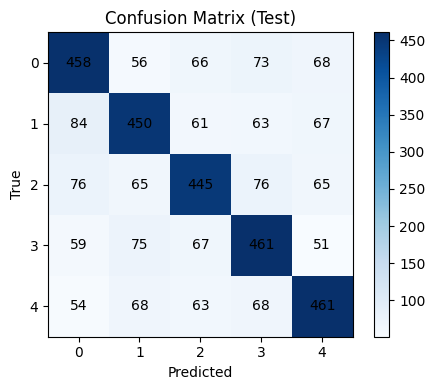


Sample Misclassifications (first 10):


,idx,true,pred,context,choice_0,choice_1,choice_2,choice_3,choice_4
0,0,4,2,"v. Power Auth. of the State of New York, 81 N....",holding that actual damages under respa includ...,holding that increased fear of flooding was a ...,holding that local buyers fear of possible kna...,recognizing concept of stigma damages as they ...,holding that stigma damages were properly incl...
1,2,4,2,that it did not impact the outcome of the defe...,holding that a suspects invocation of the righ...,holding defendants rights not scrupulously hon...,holding police violated edwards when they cont...,holding that police may continue questioning a...,holding that the admissibility of statements o...
2,4,3,1,"Phillips, 807 So.2d at 718. Based on Blackshea...",holding that defendant may be subject to death...,holding that the death penalty is unconstituti...,holding that leaning towards the death penalty...,holding that the defendant lacked standing to ...,holding that plaintiffs lacked standing to sue
3,5,4,3,Id. (internal quotations and citations omitted...,holding that impeachment by use of prearrest s...,holding that exclusion of testimony as collate...,holding that even if the minimum mandatory exc...,holding references to a defendants lack of rem...,holding that application of statutory mandator...
4,9,2,4,"(9th Cir.1986)). Notably, in their reply, Peti...",holding that if an applicant fails to meet the...,holding that the standard for withholding of r...,holding that an applicant who fails to satisfy...,recognizing that a withholding of removal clai...,holding that an alien who has failed the wellf...
5,10,2,3,"marshals, and presenting the testimony of Dr. ...",holding the state must prove that at the time ...,holding that the crime of rape is a lesser inc...,holding that felonymurder rule applies wheneve...,holding that a defendant may be convicted of f...,holding that reversal of conviction for felony...
6,11,3,2,that the veteran “may win or lose on the facts...,holding that the denial of a motion to remand ...,holding that a remand need not be ordered desp...,holding that a district courts remand order ef...,holding that a remand is appealable only when ...,holding that the fourth circuit has jurisdicti...
7,12,4,3,considered by the jury in its sentencing delib...,holding that the standard for a motion for jud...,holding the applicable standard of review in a...,holding that the standard of proof for dischar...,holding that jackson standard is only standard...,holding that the standard of review for the su...
8,13,2,0,"reference the Maersk Sealand Bill of Lading, w...",holding that bill of lading not charterparty g...,holding that forum selection clause in a bill ...,holding that bill of lading issued as to two c...,holding that terms of bill of lading apply to ...,holding that the meritorious defense requireme...
9,15,0,3,forfeiture and to offer him a fair chance to p...,holding sufficient notice by certified mail to...,holding us mail sufficient to give notice but ...,holding rules of civil procedure are appropria...,holding that property owner was not entitled t...,holding that if service done by certified mail...


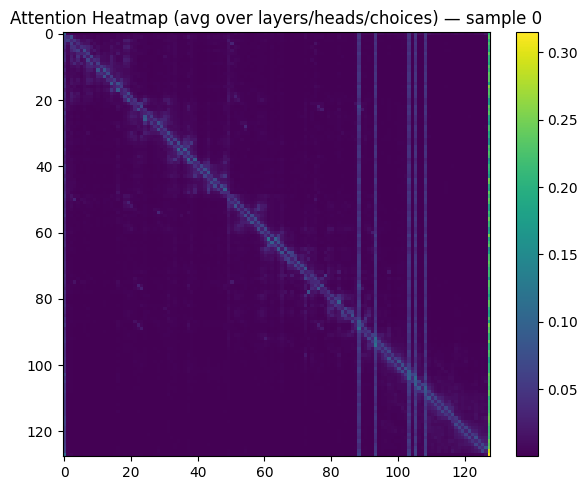


All done.


In [10]:
# ======================
# 10) Run
# ======================
trainer = single_run_train_eval()
dump_attention_heatmaps(trainer, num_samples=CFG.ATTENTION_SAMPLES)

print("\nAll done.")


In [11]:
# ===========================================
# A) Performance-tuning helpers (patched)
#    - backbone swap (LegalBERT / RoBERTa)
#    - re-tokenize per config
#    - early stopping (fixed)
#    - gradient checkpointing (for longer seq)
#    - label smoothing + group_by_length
# ===========================================
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments
from transformers.trainer_utils import IntervalStrategy
from transformers.trainer_callback import EarlyStoppingCallback

def encode_casehold_for_config(train_ds, val_ds, test_ds, model_name, max_length):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def _pp(examples):
        first = [[c] * 5 for c in examples["context"]]   # 5 choices per sample
        endings = examples["endings"]
        flat_ctx  = sum(first, [])
        flat_end  = sum(endings, [])
        enc = tok(flat_ctx, flat_end, truncation=True, max_length=max_length, padding=False)
        out = {k: [v[i:i+5] for i in range(0, len(v), 5)] for k, v in enc.items()}  # unflatten
        out["labels"] = examples["label"]
        return out

    enc_train = train_ds.map(_pp, batched=True, remove_columns=train_ds.column_names)
    enc_val   = val_ds.map(_pp,   batched=True, remove_columns=val_ds.column_names)
    enc_test  = test_ds.map(_pp,  batched=True, remove_columns=test_ds.column_names)
    return tok, enc_train, enc_val, enc_test

def train_eval_once(model_name, max_length=128, epochs=3, lr=2e-5,
                    train_ds=None, val_ds=None, test_ds=None,
                    per_device_bs=2, grad_accum=4, warmup_ratio=0.06,
                    fp16=True, patience=1, group_by_length=True,
                    label_smoothing=0.1):
    # Re-tokenize per config
    tok, enc_train, enc_val, enc_test = encode_casehold_for_config(
        train_ds, val_ds, test_ds, model_name, max_length
    )

    # Model with eager attention to silence SDPA warning
    model = AutoModelForMultipleChoice.from_pretrained(
        model_name, attn_implementation="eager"
    ).to(device)

    # Gradient checkpointing helps fit longer sequences on Colab
    try:
        model.gradient_checkpointing_enable()
    except Exception:
        pass

    args = TrainingArguments(
        output_dir="/content/tmp_tune",                  # temp; we don't rely on saved files
        num_train_epochs=epochs,
        per_device_train_batch_size=per_device_bs,
        per_device_eval_batch_size=per_device_bs,
        gradient_accumulation_steps=grad_accum,
        eval_strategy=IntervalStrategy.EPOCH,
        save_strategy=IntervalStrategy.NO,              # don't save checkpoints
        learning_rate=lr,
        weight_decay=0.01,
        warmup_ratio=warmup_ratio,
        logging_steps=50,
        load_best_model_at_end=False,                   # fine (we're not saving anyway)
        metric_for_best_model="eval_accuracy",          # <-- REQUIRED for EarlyStopping
        greater_is_better=True,
        fp16=fp16,
        report_to="none",
        group_by_length=group_by_length,
        dataloader_pin_memory=True,
        label_smoothing_factor=label_smoothing,         # small smoothing can help MC stability
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=enc_train,
        eval_dataset=enc_val,
        processing_class=tok,                           # (use one of tokenizer/processing_class)
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )

    trainer.train()
    val_metrics  = trainer.evaluate(enc_val)
    test_metrics = trainer.evaluate(enc_test)

    # Display quick report
    print(f"\n[CONFIG] model={model_name}  max_len={max_length}  lr={lr}  epochs={epochs}  "
          f"smoothing={label_smoothing}")
    print("Validation:", val_metrics)
    print("Test      :", test_metrics)
    return {
        "model": model_name,
        "max_len": max_length,
        "lr": lr,
        "epochs": epochs,
        "smooth": label_smoothing,
        "val_acc": val_metrics.get("eval_accuracy"),
        "val_f1":  val_metrics.get("eval_macro_f1"),
        "test_acc": test_metrics.get("eval_accuracy"),
        "test_f1":  test_metrics.get("eval_macro_f1"),
    }


In [ ]:
# =================================================
# B) Quick sweep on a subset to pick a better config
#     - RoBERTa often helps on CaseHOLD
#     - Try longer max_len with grad checkpointing
#     - Try lower LR
# =================================================
import pandas as pd

SWEEP_TRAIN_N = 4000
SWEEP_VAL_N   = 800
train_sub = ds["train"].select(range(min(SWEEP_TRAIN_N, len(ds["train"]))))
val_sub   = ds["validation"].select(range(min(SWEEP_VAL_N, len(ds["validation"]))))
test_full = ds["test"]  # keep full test for meaningful evaluation

model_grid = [
    "nlpaueb/legal-bert-base-uncased",  # LegalBERT
    "roberta-base",                     # often strong
]
len_grid   = [128, 256]
lr_grid    = [2e-5, 1e-5]
smoothing  = [0.0, 0.1]                # try a bit of label smoothing
epochs     = 3

results = []
for m in model_grid:
    for L in len_grid:
        for lr in lr_grid:
            for sm in smoothing:
                try:
                    res = train_eval_once(
                        model_name=m,
                        max_length=L,
                        epochs=epochs,
                        lr=lr,
                        train_ds=train_sub,
                        val_ds=val_sub,
                        test_ds=test_full,
                        per_device_bs=2,
                        grad_accum=4,
                        warmup_ratio=0.06,
                        fp16=torch.cuda.is_available(),
                        patience=1,                  # stop early if not improving
                        group_by_length=True,
                        label_smoothing=sm,
                    )
                    results.append(res)
                except RuntimeError as e:
                    print(f"OOM/RuntimeError for model={m}, max_len={L}, lr={lr}, smoothing={sm} -> {e}")

# Show top configs
if results:
    df = pd.DataFrame(results).sort_values(["val_acc", "val_f1"], ascending=False)
    display(df.reset_index(drop=True).head(10))
else:
    print("No successful runs in sweep. Reduce max_len to 128 only or test one model at a time.")


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.004500,0.888229,0.637500,0.636664
2,0.558600,0.988433,0.631250,0.629949



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=128  lr=2e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 0.988432765007019, 'eval_accuracy': 0.63125, 'eval_macro_f1': 0.6299486157984221, 'eval_runtime': 9.9713, 'eval_samples_per_second': 80.23, 'eval_steps_per_second': 40.115, 'epoch': 2.0}
Test      : {'eval_loss': 1.0297932624816895, 'eval_accuracy': 0.6172222222222222, 'eval_macro_f1': 0.6171992251817011, 'eval_runtime': 46.9563, 'eval_samples_per_second': 76.667, 'eval_steps_per_second': 38.334, 'epoch': 2.0}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.114900,1.058544,0.648750,0.646702
2,0.823400,1.089030,0.633750,0.632573



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=128  lr=2e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 1.089030146598816, 'eval_accuracy': 0.63375, 'eval_macro_f1': 0.6325729438237861, 'eval_runtime': 9.8252, 'eval_samples_per_second': 81.423, 'eval_steps_per_second': 40.712, 'epoch': 2.0}
Test      : {'eval_loss': 1.1128060817718506, 'eval_accuracy': 0.6247222222222222, 'eval_macro_f1': 0.6246832136412791, 'eval_runtime': 46.7323, 'eval_samples_per_second': 77.034, 'eval_steps_per_second': 38.517, 'epoch': 2.0}


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.002600,0.918664,0.630000,0.629424
2,0.679300,0.928036,0.637500,0.637792
3,0.631700,0.998312,0.628750,0.628780



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=128  lr=1e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 0.9983118176460266, 'eval_accuracy': 0.62875, 'eval_macro_f1': 0.6287803234663134, 'eval_runtime': 9.7496, 'eval_samples_per_second': 82.055, 'eval_steps_per_second': 41.028, 'epoch': 3.0}
Test      : {'eval_loss': 1.0088797807693481, 'eval_accuracy': 0.615, 'eval_macro_f1': 0.614980933862391, 'eval_runtime': 46.3583, 'eval_samples_per_second': 77.656, 'eval_steps_per_second': 38.828, 'epoch': 3.0}


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.154000,1.070723,0.627500,0.625840
2,0.915200,1.072016,0.643750,0.642860
3,0.915700,1.089651,0.642500,0.641634



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=128  lr=1e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 1.0896514654159546, 'eval_accuracy': 0.6425, 'eval_macro_f1': 0.6416339699604643, 'eval_runtime': 9.8048, 'eval_samples_per_second': 81.592, 'eval_steps_per_second': 40.796, 'epoch': 3.0}
Test      : {'eval_loss': 1.1140921115875244, 'eval_accuracy': 0.6197222222222222, 'eval_macro_f1': 0.6197611912456186, 'eval_runtime': 47.1408, 'eval_samples_per_second': 76.367, 'eval_steps_per_second': 38.184, 'epoch': 3.0}


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.812900,0.658958,0.746250,0.744107
2,0.514100,0.641340,0.747500,0.745122
3,0.379200,0.711409,0.747500,0.746492



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=256  lr=2e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 0.7114570736885071, 'eval_accuracy': 0.7475, 'eval_macro_f1': 0.7464919381827653, 'eval_runtime': 19.7483, 'eval_samples_per_second': 40.51, 'eval_steps_per_second': 20.255, 'epoch': 3.0}
Test      : {'eval_loss': 0.7469989061355591, 'eval_accuracy': 0.7336111111111111, 'eval_macro_f1': 0.7336315954541348, 'eval_runtime': 90.4097, 'eval_samples_per_second': 39.819, 'eval_steps_per_second': 19.909, 'epoch': 3.0}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.972000,0.865270,0.765000,0.764055
2,0.737400,0.871359,0.753750,0.753625



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=256  lr=2e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 0.8713258504867554, 'eval_accuracy': 0.75375, 'eval_macro_f1': 0.7536246795688234, 'eval_runtime': 19.5428, 'eval_samples_per_second': 40.936, 'eval_steps_per_second': 20.468, 'epoch': 2.0}
Test      : {'eval_loss': 0.9202409386634827, 'eval_accuracy': 0.7355555555555555, 'eval_macro_f1': 0.7355371981953407, 'eval_runtime': 90.9379, 'eval_samples_per_second': 39.587, 'eval_steps_per_second': 19.794, 'epoch': 2.0}


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.780800,0.622158,0.747500,0.746426
2,0.502400,0.619801,0.748750,0.747483
3,0.420800,0.668848,0.740000,0.739059



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=256  lr=1e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 0.6688752770423889, 'eval_accuracy': 0.74, 'eval_macro_f1': 0.7390585344468821, 'eval_runtime': 19.7222, 'eval_samples_per_second': 40.563, 'eval_steps_per_second': 20.282, 'epoch': 3.0}
Test      : {'eval_loss': 0.751941978931427, 'eval_accuracy': 0.7269444444444444, 'eval_macro_f1': 0.7269417866589636, 'eval_runtime': 91.2665, 'eval_samples_per_second': 39.445, 'eval_steps_per_second': 19.722, 'epoch': 3.0}


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.968700,0.861259,0.753750,0.752581
2,0.805100,0.869843,0.750000,0.748630



[CONFIG] model=nlpaueb/legal-bert-base-uncased  max_len=256  lr=1e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 0.8698386549949646, 'eval_accuracy': 0.75, 'eval_macro_f1': 0.7486297450258721, 'eval_runtime': 19.7372, 'eval_samples_per_second': 40.533, 'eval_steps_per_second': 20.266, 'epoch': 2.0}
Test      : {'eval_loss': 0.9170814156532288, 'eval_accuracy': 0.7333333333333333, 'eval_macro_f1': 0.7333179701021937, 'eval_runtime': 90.9849, 'eval_samples_per_second': 39.567, 'eval_steps_per_second': 19.784, 'epoch': 2.0}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.118000,1.040106,0.568750,0.567306
2,0.867100,1.092431,0.582500,0.581049
3,0.730400,1.089677,0.597500,0.595389



[CONFIG] model=roberta-base  max_len=128  lr=2e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 1.0896769762039185, 'eval_accuracy': 0.5975, 'eval_macro_f1': 0.5953889389953891, 'eval_runtime': 9.6262, 'eval_samples_per_second': 83.107, 'eval_steps_per_second': 41.553, 'epoch': 3.0}
Test      : {'eval_loss': 1.1595244407653809, 'eval_accuracy': 0.5777777777777777, 'eval_macro_f1': 0.5777725620311646, 'eval_runtime': 46.3699, 'eval_samples_per_second': 77.637, 'eval_steps_per_second': 38.818, 'epoch': 3.0}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.233900,1.152338,0.593750,0.591574
2,0.996900,1.171668,0.605000,0.603900
3,0.926400,1.195102,0.616250,0.615066



[CONFIG] model=roberta-base  max_len=128  lr=2e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 1.195102334022522, 'eval_accuracy': 0.61625, 'eval_macro_f1': 0.6150661547414741, 'eval_runtime': 9.6824, 'eval_samples_per_second': 82.624, 'eval_steps_per_second': 41.312, 'epoch': 3.0}
Test      : {'eval_loss': 1.2402993440628052, 'eval_accuracy': 0.58, 'eval_macro_f1': 0.5800312070778051, 'eval_runtime': 46.1738, 'eval_samples_per_second': 77.966, 'eval_steps_per_second': 38.983, 'epoch': 3.0}


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.246600,1.159288,0.573750,0.572343
2,0.979100,1.036695,0.586250,0.584370
3,0.942200,1.036418,0.578750,0.576379



[CONFIG] model=roberta-base  max_len=128  lr=1e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 1.0364177227020264, 'eval_accuracy': 0.57875, 'eval_macro_f1': 0.5763794000449454, 'eval_runtime': 9.6466, 'eval_samples_per_second': 82.931, 'eval_steps_per_second': 41.465, 'epoch': 3.0}
Test      : {'eval_loss': 1.1048141717910767, 'eval_accuracy': 0.5719444444444445, 'eval_macro_f1': 0.5719577951713614, 'eval_runtime': 45.9557, 'eval_samples_per_second': 78.336, 'eval_steps_per_second': 39.168, 'epoch': 3.0}


Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.260600,1.152827,0.582500,0.580206
2,1.074600,1.140975,0.593750,0.590134
3,1.015600,1.149893,0.588750,0.586304



[CONFIG] model=roberta-base  max_len=128  lr=1e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 1.1498926877975464, 'eval_accuracy': 0.58875, 'eval_macro_f1': 0.5863043264380796, 'eval_runtime': 9.5677, 'eval_samples_per_second': 83.615, 'eval_steps_per_second': 41.808, 'epoch': 3.0}
Test      : {'eval_loss': 1.2023751735687256, 'eval_accuracy': 0.5725, 'eval_macro_f1': 0.5725195111466173, 'eval_runtime': 47.132, 'eval_samples_per_second': 76.381, 'eval_steps_per_second': 38.191, 'epoch': 3.0}


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.857700,0.758781,0.708750,0.707205
2,0.606700,0.735102,0.723750,0.722059
3,0.533800,0.804684,0.725000,0.722881



[CONFIG] model=roberta-base  max_len=256  lr=2e-05  epochs=3  smoothing=0.0
Validation: {'eval_loss': 0.8046131730079651, 'eval_accuracy': 0.725, 'eval_macro_f1': 0.7228810504794585, 'eval_runtime': 19.3673, 'eval_samples_per_second': 41.307, 'eval_steps_per_second': 20.653, 'epoch': 3.0}
Test      : {'eval_loss': 0.895392656326294, 'eval_accuracy': 0.6991666666666667, 'eval_macro_f1': 0.6992308187592934, 'eval_runtime': 89.1665, 'eval_samples_per_second': 40.374, 'eval_steps_per_second': 20.187, 'epoch': 3.0}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.064900,0.944005,0.711250,0.709588
2,0.853800,0.934991,0.730000,0.728044
3,0.793400,0.948142,0.722500,0.720943



[CONFIG] model=roberta-base  max_len=256  lr=2e-05  epochs=3  smoothing=0.1
Validation: {'eval_loss': 0.9481419920921326, 'eval_accuracy': 0.7225, 'eval_macro_f1': 0.7209427910186662, 'eval_runtime': 19.4049, 'eval_samples_per_second': 41.227, 'eval_steps_per_second': 20.613, 'epoch': 3.0}
Test      : {'eval_loss': 1.0044223070144653, 'eval_accuracy': 0.6991666666666667, 'eval_macro_f1': 0.699258310668639, 'eval_runtime': 89.3945, 'eval_samples_per_second': 40.271, 'eval_steps_per_second': 20.135, 'epoch': 3.0}


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss
